Environment: `py39_torch271`

In [1]:
import os
import random

from typing import Optional
from dataclasses import dataclass, asdict
from pathlib import Path
from datetime import datetime

import torch
import numpy as np
import pandas as pd
from dacite import from_dict
from sklearn.model_selection import train_test_split

from pyrutils.torch.train_utils import train, save_checkpoint
from pyrutils.torch.multi_task import MultiTaskLossLearner
from vhoi.data_loading import (
    input_size_from_data_loader, 
    select_model_data_feeder, 
    select_model_data_fetcher,
)
from vhoi.data_loading_custom import (
    create_data,
    create_data_loader
)
from vhoi.losses import (
    select_loss, 
    decide_num_main_losses, 
    select_loss_types, 
    select_loss_learning_mask,
)
from vhoi.models import load_model_weights
from vhoi.models_custom import TGGCN

seed = 42
random.seed(seed)   # Python的随机性
os.environ['PYTHONHASHSEED'] = str(seed)    # 设置Python哈希种子，为了禁止hash随机化，使得实验可复现
np.random.seed(seed)   # numpy的随机性
torch.manual_seed(seed)   # torch的CPU随机性，为CPU设置随机种子
torch.cuda.manual_seed(seed)   # torch的GPU随机性，为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.   torch的GPU随机性，为所有GPU设置随机种子
torch.backends.cudnn.benchmark = False   # if benchmark=True, deterministic will be False
torch.backends.cudnn.deterministic = True   # 选择确定性算法

In [2]:
class DictMixin:
    def get(self, key, default_value=None):
        return getattr(self, key, default_value)

    def as_dict(self):
        return asdict(self)
    
@dataclass
class Resources(DictMixin):
    use_gpu: bool
    num_threads: int

@dataclass
class ModelMetadata(DictMixin):
    model_name: str
    input_type: str

@dataclass
class ModelParameters(DictMixin):
    add_segment_length: int
    add_time_position: int
    time_position_strategy: str
    positional_encoding_style: str
    attention_style: str
    bias: bool
    cat_level_states: int
    discrete_networks_num_layers: int
    discrete_optimization_strategy: str
    filter_discrete_updates: bool
    gcn_node: int
    hidden_size: int
    message_humans_to_human: bool
    message_human_to_objects: bool
    message_objects_to_human: bool
    message_objects_to_object: bool
    message_geometry_to_objects: bool
    message_geometry_to_human: bool
    message_segment: bool
    message_type: str
    message_granularity: str
    message_aggregation: str
    object_segment_update_strategy: str
    share_level_mlps: int
    update_segment_threshold: float

@dataclass
class ModelOptimization(DictMixin):
    batch_size: int
    clip_gradient_at: float
    epochs: int
    learning_rate: float
    val_fraction: float

@dataclass
class BudgetLoss(DictMixin):
    add: bool
    human_weight: float
    object_weight: float

@dataclass
class SegmentationLoss(DictMixin):
    add: bool
    pretrain: bool
    sigma: float
    weight: float

@dataclass
class ModelMisc(DictMixin):
    anticipation_loss_weight: float
    budget_loss: BudgetLoss
    first_level_loss_weight: float
    impose_segmentation_pattern: int
    input_human_segmentation: bool
    input_object_segmentation: bool
    make_attention_distance_based: bool
    multi_task_loss_learner: bool
    pretrained: bool
    pretrained_path: Optional[str]
    segmentation_loss: SegmentationLoss

@dataclass
class ModelLogging(DictMixin):
    root_log_dir: str
    checkpoint_name: str
    log_dir: str

@dataclass
class Models(DictMixin):
    metadata: ModelMetadata
    parameters: ModelParameters
    optimization: ModelOptimization
    misc: ModelMisc
    logging: ModelLogging

@dataclass
class Data(DictMixin):
    name: str
    path: str
    path_zarr: str
    path_obb_zarr: str
    path_hbb_zarr: str
    path_hps_zarr: str
    cross_validation_test_subject: str
    scaling_strategy: Optional[str]
    downsampling: int

@dataclass
class Config(DictMixin):
    resources: Resources
    models: Models
    data: Data
    
metadata_dict = {
    "model_name": "2G-GCN",
    "input_type": "multiple"
}

parameters_dict = {
    "add_segment_length": 0,  # length of the segment to the segment-level rnn. 0 is off and 1 is on.
    "add_time_position": 0,  # absolute time position to the segment-level rnn. 0 is off and 1 is on.
    "time_position_strategy": "s",  # input time position to segment [s] or discrete update [u].
    "positional_encoding_style": "e",  # e [embedding] or p [periodic].
    "attention_style": "v3",  # v1 [concat], v2 [dot-product], v3 [scaled_dot-product], v4 [general]
    "bias": True,
    "cat_level_states": 0,  # concatenate first and second level hidden states for predictors MLPs.
    "discrete_networks_num_layers": 1,  # depth of the state change detector MLP.
    "discrete_optimization_strategy": "gs",  # straight-through [st] or gumbel-sigmoid [gs]
    "filter_discrete_updates": False,  # maxima filter for soft output of state change detector.
    "gcn_node": 25,  # custom, original: 19 for cad120, 30 for bimanual, 26 for mphoi
    "hidden_size": 512,  # 512 for cad120 & mphoi; 64 for bimanual
    "message_humans_to_human": False, # custom, original: True
    "message_human_to_objects": True,
    "message_objects_to_human": True,
    "message_objects_to_object": False, # custom, original: True
    "message_geometry_to_objects": True,
    "message_geometry_to_human": True,  # custom, original: False
    "message_segment": True,
    "message_type": "v2",  # v1 [relational] or v2 [non-relational]
    "message_granularity": "v1",  # v1 [generic] or v2 [specific]
    "message_aggregation": "att",  # mean_pooling [mp] or attention [att]
    "object_segment_update_strategy": "ind",  # same_as_human [sah], independent [ind], or conditional_on_human [coh]
    "share_level_mlps": 0,  # whether to share [1] or not [0] the prediction MLPs of the levels.
    "update_segment_threshold": 0.5  # [0.0, 1.0)
}

optimization_dict = {
    "batch_size": 8,  # mphoi:8; cad120:16; bimanual: 32
    "clip_gradient_at": 0.0,
    "epochs": 10, # custom, original: cad120 & mphoi:40; bimanual: 60
    "learning_rate": 1e-4,  # mphoi:1e-4; cad120 & bimanual:1e-3
    "val_fraction": 0.1
}

data_dict = {
    "name": "mphoi",
    "path": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_ground_truth_labels.json",
    "path_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/faster_rcnn.zarr",
    "path_obb_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/object_bounding_boxes.zarr",
    "path_hbb_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/human_bounding_boxes.zarr",
    "path_hps_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/human_pose.zarr",
    "cross_validation_test_subject": "Subject14",  # Subject45, Subject25, Subject14
    "scaling_strategy": None,  # null or "standard"
    "downsampling": 1 # custom, original: 3, 1 = full FPS, 2 = half FPS, ...
}

# root_log_dir = f"{os.getcwd()}/outputs_hiergat/{data_dict['name']}/{metadata_dict['model_name']}"
root_log_dir = f"{os.getcwd()}/outputs_hiergat/custom"
checkpoint_name = (
    f"hs{parameters_dict['hidden_size']}_e{optimization_dict['epochs']}_bs{optimization_dict['batch_size']}_"
    f"lr{optimization_dict['learning_rate']}_{parameters_dict['update_segment_threshold']}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
)
log_dir = f"{root_log_dir}/{checkpoint_name}"
print("Log directory:", log_dir)
os.makedirs(log_dir, exist_ok=True)

cfg_dict = {
    "resources": {
        "use_gpu": True,
        "num_threads": 32
    },
    "models": {
        "metadata": metadata_dict,
        "parameters": parameters_dict,
        "optimization": optimization_dict,
        "misc": {
            "anticipation_loss_weight": 1.0,
            "budget_loss": {
                "add": False,
                "human_weight": 1.0,
                "object_weight": 1.0
            },
            "first_level_loss_weight": 0.0,  # if positive, first level does frame-level prediction
            "impose_segmentation_pattern": 1,  # 0 [no pattern], 1 [all ones]
            "input_human_segmentation": False,  # (was "flase" in YAML, corrected here)
            "input_object_segmentation": False,
            "make_attention_distance_based": True,  # only meaningful if message_aggregation is attention
            "multi_task_loss_learner": False,
            "pretrained": False,  # unfortunately need two entries for checkpoint name
            "pretrained_path": None,  # specified parameters must match pre-trained model
            "segmentation_loss": {
                "add": False,
                "pretrain": False,
                "sigma": 0.0,  # Gaussian smoothing
                "weight": 1.0
            }
        },
        "logging": {
            "root_log_dir": root_log_dir,
            "checkpoint_name": checkpoint_name,
            "log_dir": log_dir
        },
    },
    "data": data_dict,
}

cfg = from_dict(data_class=Config, data=cfg_dict)

torch.set_num_threads(cfg.resources.num_threads)
model_name, model_input_type = cfg.models.metadata.model_name, cfg.models.metadata.input_type
batch_size, val_fraction = cfg.models.optimization.batch_size, cfg.models.optimization.val_fraction
misc_dict = cfg.get('misc', default_value={})
sigma = misc_dict.get('segmentation_loss', {}).get('sigma', 0.0)
scaling_strategy = cfg.data.scaling_strategy
downsampling = cfg.data.downsampling

action_classes = [
    # human
    'supervise',        # 0
    'collaborate with', # 1
    'assist',           # 2
    'lead',             # 3
    'coordinate with',  # 4
    'listen to',        # 5

    # rebar
    'tie',              # 6
    'erect',            # 7
    'prepare_rebar',    # 8
    'transport',        # 9

    # formwork
    'install',          # 10
    'prepare_formwork', # 11

    # concrete
    'pour',             # 12
    'finish',           # 13

    # equipment         
    'use',              # 14
    'carry',            # 15

    # all
    'inspect',          # 16
    'no interaction',   # 17
]
new_action_classes = [
    # rebar
    'tie',              # 0
    'erect',            # 1
    'prepare_rebar',    # 2
    'transport',        # 3

    # equipment         
    'use',              # 4
    'carry',            # 5

    # all
    'inspect',          # 6
    'no interaction',   # 7
]
num_classes = len(new_action_classes)
features_dirs = [
    # 1
    Path('/root/vs-gats-plaster/deepsort/outputs/C0496_r_full_temporal_3s/features'),
    Path('/root/vs-gats-plaster/deepsort/outputs/C0505_r_full_temporal_3s/features'),
    Path('/root/vs-gats-plaster/deepsort/outputs/C0510_r_full_temporal_3s/features'),
    Path('/root/vs-gats-plaster/deepsort/outputs/C0511_r_full_temporal_3s/features'),
    Path('/root/vs-gats-plaster/deepsort/outputs/C0513_r_full_temporal_3s/features'),
    Path('/root/vs-gats-plaster/deepsort/outputs/C0514_r_full_temporal_3s/features'),
    Path('/root/vs-gats-plaster/deepsort/outputs/C0517_r_full_temporal_3s/features'), 
    Path('/root/vs-gats-plaster/deepsort/outputs/C0518_r_full_temporal_3s/features'), 
    Path('/root/vs-gats-plaster/deepsort/outputs/C0520_r_full_temporal_3s/features'),
    
    # 2
    # Path('/root/vs-gats-plaster/deepsort/outputs/C0574_full_temporal_3s/features'),
    # Path('/root/vs-gats-plaster/deepsort/outputs/C0577_full_temporal_3s/features'),
    
    # 3
    # Path("/root/vs-gats-plaster/deepsort/outputs/C0529_c_full_temporal_3s/features"),
    # Path("/root/vs-gats-plaster/deepsort/outputs/C0531_c_full_temporal_3s/features"),
    # Path("/root/vs-gats-plaster/deepsort/outputs/C0532_c_full_temporal_3s/features"),
    # Path("/root/vs-gats-plaster/deepsort/outputs/C0534_c_full_temporal_3s/features"),
    # Path("/root/vs-gats-plaster/deepsort/outputs/C0535_c_full_temporal_3s/features"),
    # Path("/root/vs-gats-plaster/deepsort/outputs/C0537_c_full_temporal_3s/features"),
    # Path("/root/vs-gats-plaster/deepsort/outputs/C0539_c_full_temporal_3s/features"),
]

Log directory: /root/workspace/HierGAT-2025/outputs_hiergat/custom/hs512_e10_bs8_lr0.0001_0.5_20250919000934


In [3]:
# Data
feature_dirs_dict = []
for features_dir in features_dirs:
    for dir in features_dir.iterdir():
        action_label = int(str(dir).rsplit('_action_')[-1])
        action_class = action_classes[action_label]
        try:
            new_action_label = new_action_classes.index(action_class)
        except ValueError:
            new_action_label = -1
        feature_dirs_dict.append({
            'dir': dir,
            'action_label': action_label,
            'new_action_label': new_action_label,
        })
feature_dirs_df = pd.DataFrame(feature_dirs_dict)
feature_dirs_df = feature_dirs_df[feature_dirs_df['new_action_label'] != -1] # remove rows where action_label == -1

print("New action label counts:")
print(feature_dirs_df['new_action_label'].value_counts())

New action label counts:
new_action_label
6    553
7    356
3    125
5    121
1     93
0     64
Name: count, dtype: int64


In [4]:
# def downsample_to_second_largest(df, label_col, seed):
#     # Count samples per class
#     label_counts = df[label_col].value_counts()
    
#     # Identify largest and second largest class counts
#     largest_label = label_counts.idxmax()
#     second_largest_count = label_counts.iloc[1]
    
#     # Split largest class and others
#     largest_df = df[df[label_col] == largest_label]
#     others_df  = df[df[label_col] != largest_label]
    
#     # Downsample largest class to match second largest
#     largest_df_downsampled = largest_df.sample(n=second_largest_count, random_state=seed)
    
#     # Combine and shuffle
#     df_balanced = pd.concat([largest_df_downsampled, others_df])
#     df_balanced = df_balanced.sample(frac=1, random_state=seed).reset_index(drop=True)
#     return df_balanced

# feature_dirs_df_balanced = downsample_to_second_largest(
#     feature_dirs_df,
#     label_col='action_label',
#     seed=seed
# )

# print("Action label counts (balanced):")
# print(feature_dirs_df_balanced['action_label'].value_counts())

In [5]:
def downsample_majority(df, label_col, majority_label, n_samples, seed):
    majority_df = df[df[label_col] == majority_label]
    others_df   = df[df[label_col] != majority_label]
    majority_df_downsampled = majority_df.sample(n=n_samples, random_state=seed)
    df_balanced = pd.concat([majority_df_downsampled, others_df])
    df_balanced = df_balanced.sample(frac=1, random_state=seed).reset_index(drop=True) # shuffle
    return df_balanced

feature_dirs_df_balanced = downsample_majority(
    feature_dirs_df,
    label_col='new_action_label',
    majority_label=6,
    n_samples=356,
    seed=seed
)

print("New action label value counts (balanced):")
print(feature_dirs_df_balanced['new_action_label'].value_counts())

New action label value counts (balanced):
new_action_label
6    356
7    356
3    125
5    121
1     93
0     64
Name: count, dtype: int64


In [6]:
def stratified_split_with_minority(df, label_col, test_size, seed):
    # Identify minority and majority classes
    label_counts = df[label_col].value_counts()
    minority_labels = label_counts[label_counts < 2].index
    minority_df = df[df[label_col].isin(minority_labels)]
    others_df = df[~df[label_col].isin(minority_labels)]

    # Split only the majority classes
    train_df, test_df = train_test_split(
        others_df,
        test_size=test_size,
        stratify=others_df[label_col],
        random_state=seed
    )

    # Add back minority samples & shuffle
    train_df = pd.concat([train_df, minority_df]).sample(frac=1, random_state=seed).reset_index(drop=True)
    return train_df, test_df

train_df, val_test_df = stratified_split_with_minority(
    feature_dirs_df_balanced,
    label_col='new_action_label',
    test_size=val_fraction*2,
    seed=seed
)
val_df, test_df = stratified_split_with_minority(
    val_test_df,
    label_col='new_action_label',
    test_size=0.5,
    seed=seed
)

train_feature_dirs = train_df['dir'].tolist()
val_feature_dirs   = val_df['dir'].tolist()
test_feature_dirs  = test_df['dir'].tolist()

In [7]:
# TODO: Implement new_label_map instead passing action_classes and new_action_classes
train_data = create_data(train_feature_dirs, action_classes, new_action_classes)
val_data = create_data(val_feature_dirs, action_classes, new_action_classes)
test_data = create_data(test_feature_dirs, action_classes, new_action_classes)

train_loader, scalers, _ = create_data_loader(
    *train_data, 
    model_name, 
    batch_size=batch_size, 
    shuffle=True,
    scaling_strategy=scaling_strategy, 
    sigma=sigma,
    downsampling=downsampling,
)
val_loader, _, _ = create_data_loader(
    *val_data, 
    model_name, 
    batch_size=len(val_data[0]),
    shuffle=False, 
    scalers=scalers, 
    sigma=sigma, 
    downsampling=downsampling,
)
test_loader, _, _ = create_data_loader(
    *test_data, 
    model_name, 
    batch_size=len(test_data[0]),
    shuffle=False, 
    scalers=scalers, 
    sigma=sigma, 
    downsampling=downsampling,
)
input_size = input_size_from_data_loader(train_loader, model_name, model_input_type)
data_info = {'input_size': input_size}

In [8]:
# Model
model_creation_args = cfg.models.parameters
model_creation_args = {**data_info, **model_creation_args.__dict__}
dataset_name = cfg.data.name
model_creation_args['num_classes'] = (num_classes, None)
device = 'cuda' if torch.cuda.is_available() and cfg.resources.use_gpu else 'cpu'
model = TGGCN(feat_dim=1024, **model_creation_args).to(device)
if misc_dict.get('pretrained', False) and misc_dict.get('pretrained_path') is not None:
    state_dict = load_model_weights(misc_dict['pretrained_path'])
    model.load_state_dict(state_dict, strict=False)
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=cfg.models.optimization.learning_rate)
criterion, loss_names = select_loss(model_name, model_input_type, dataset_name, cfg=cfg)
mtll_model = None
if misc_dict.get('multi_task_loss_learner', False):
    loss_types = select_loss_types(model_name, dataset_name, cfg=cfg)
    mask = select_loss_learning_mask(model_name, dataset_name, cfg=cfg)
    mtll_model = MultiTaskLossLearner(loss_types=loss_types, mask=mask).to(device)
    optimizer.add_param_group({'params': mtll_model.parameters()})
# Some config + model training
tensorboard_log_dir = cfg.models.logging.root_log_dir
checkpoint_name = cfg.models.logging.checkpoint_name
fetch_model_data = select_model_data_fetcher(model_name, model_input_type,
                                             dataset_name=dataset_name, **{**misc_dict, **cfg.models.parameters.__dict__})
feed_model_data = select_model_data_feeder(model_name, model_input_type, dataset_name=dataset_name, **misc_dict)
num_main_losses = decide_num_main_losses(model_name, dataset_name, {**misc_dict, **cfg.models.parameters.__dict__})
checkpoint = train(
    model, 
    train_loader, 
    optimizer, 
    criterion, 
    cfg.models.optimization.epochs, 
    device, 
    loss_names,
    clip_gradient_at=cfg.models.optimization.clip_gradient_at,
    fetch_model_data=fetch_model_data, feed_model_data=feed_model_data,
    val_loader=val_loader, 
    mtll_model=mtll_model, 
    num_main_losses=num_main_losses,
    tensorboard_log_dir=tensorboard_log_dir, 
    checkpoint_name=checkpoint_name,
)
# Logging
if cfg.models.logging.log_dir is not None:
    log_dir = cfg.models.logging.log_dir
    checkpoint['scalers'] = scalers
    save_checkpoint(log_dir, checkpoint, checkpoint_name=checkpoint_name, include_timestamp=False)


Epoch: [   1/  10]
(Train) Batch [     8/   892 (  1%)]  Loss:   4.2021  B_HS:  0.0000  BCE_HS:  0.0000  NLL_SAR_F:  0.0000  NLL_SAP_F:  0.0000  NLL_SAR:  2.0948  NLL_SAP:  2.1073
(Train) Batch [   208/   892 ( 23%)]  Loss:   2.6369  B_HS:  0.0000  BCE_HS:  0.0000  NLL_SAR_F:  0.0000  NLL_SAP_F:  0.0000  NLL_SAR:  1.3201  NLL_SAP:  1.3168
(Train) Batch [   408/   892 ( 46%)]  Loss:   1.3911  B_HS:  0.0000  BCE_HS:  0.0000  NLL_SAR_F:  0.0000  NLL_SAP_F:  0.0000  NLL_SAR:  0.6838  NLL_SAP:  0.7073
(Train) Batch [   608/   892 ( 68%)]  Loss:   1.7946  B_HS:  0.0000  BCE_HS:  0.0000  NLL_SAR_F:  0.0000  NLL_SAP_F:  0.0000  NLL_SAR:  0.8948  NLL_SAP:  0.8998
(Train) Batch [   808/   892 ( 90%)]  Loss:   1.7180  B_HS:  0.0000  BCE_HS:  0.0000  NLL_SAR_F:  0.0000  NLL_SAP_F:  0.0000  NLL_SAR:  0.8494  NLL_SAP:  0.8686
(Train) Batch [   892/   892 (100%)]  Loss:   1.5188  B_HS:  0.0000  BCE_HS:  0.0000  NLL_SAR_F:  0.0000  NLL_SAP_F:  0.0000  NLL_SAR:  0.7866  NLL_SAP:  0.7322
     (Train) L

# Predict

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from predict import match_shape, match_att_shape

inspect_model = False

model.eval();

In [10]:
outputs, targets, attentions = [], [], []
for i, dataset in enumerate(test_loader):
    data, target = fetch_model_data(dataset, device=device)
    with torch.no_grad():
        output = feed_model_data(model, data)
    if inspect_model:
        output, attention_scores = output
        attention_scores = [att_score[:, 0] for att_score in attention_scores]
    if num_main_losses is not None:
        output = output[-num_main_losses:]
        target = target[-num_main_losses:]
    if downsampling > 1:
        for i, (out, tgt) in enumerate(zip(output, target)):
            if out.ndim != 4:
                raise RuntimeError(f'Number of dimensions for output is {out.ndim}')
            out = torch.repeat_interleave(out, repeats=downsampling, dim=-2)
            out = match_shape(out, tgt)
            output[i] = out
        if inspect_model:
            a_target = target[0]
            attention_scores = [torch.repeat_interleave(att_score, repeats=downsampling, dim=-2)
                                for att_score in attention_scores]
            attention_scores = [match_att_shape(att_score, a_target) for att_score in attention_scores]
            attentions.append(attention_scores)
    outputs += output
    targets += target

In [11]:
y_pred = torch.argmax(outputs[0], dim=1)
y_pred = y_pred.squeeze(-1).mode(dim=1).values.cpu().numpy()
y_true = targets[0].squeeze(-1).mode(dim=1).values.cpu().numpy()

In [12]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7857142857142857
F1 Score: 0.7537758929925314
Precision: 0.737440572820037
Recall: 0.7857142857142857


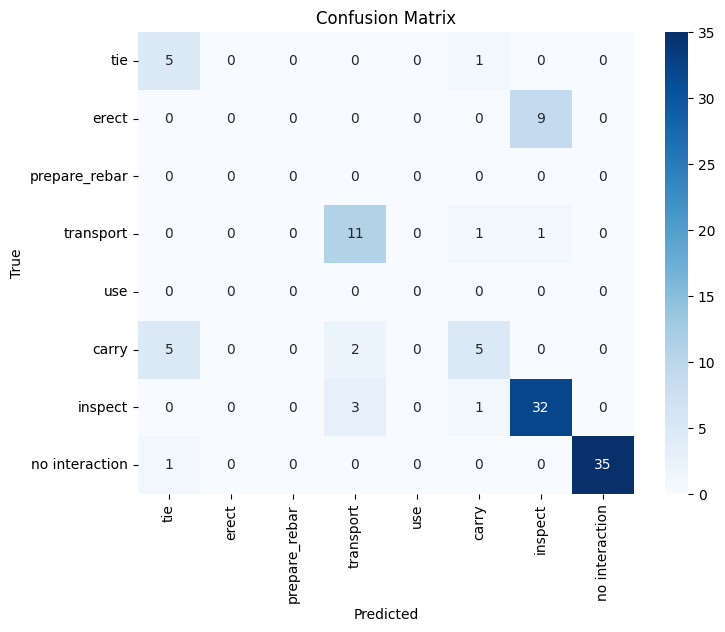

In [14]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(new_action_classes))))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=new_action_classes, yticklabels=new_action_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()